# Indicators
My attempt to reconfigure the way our trading bot handles data, for the sake of somewhat more complicated applications. All indicators must have the following traits:
1. Take in a dataframe of our data and be able to produce information up to a given index (if non is given, then we assume that the index is the end of the dataframe).
2. Specific Index agnosticism, basically if we give the indicator half a days data, or the full day's data, there should be no difference in the values.
3. Can tell you whether to enter long or short, which can be used as an exit signal in the converse.

In [1]:
%load_ext autoreload
%autoreload 2

import lib.tools.Scrivener as sc
import lib.tools.TimeKeeper as tk
import lib.tools.Toolbox as tb
import metadata.trade_configs.Globals as gb
import matplotlib.pyplot as plt

%matplotlib widget

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

class Indicator:
    def __init__(self, df:pd.DataFrame):
        self.update(df)

    def update(self, df:pd.DataFrame):
        '''Updates the indicator's series using it's own df. If the df has changed since inception, instead updates it's series with the new data'''
        self.df = df

    def get_signal(self, index:pd.Timestamp = None):
        '''Returns the indicator's entry/exit signal. If the indicator suggests upwards movement, returns 1, downwards gives -1, and range gives 0'''
        if not isinstance(index, pd.Timestamp): index = self.df.index[-1]
        return index

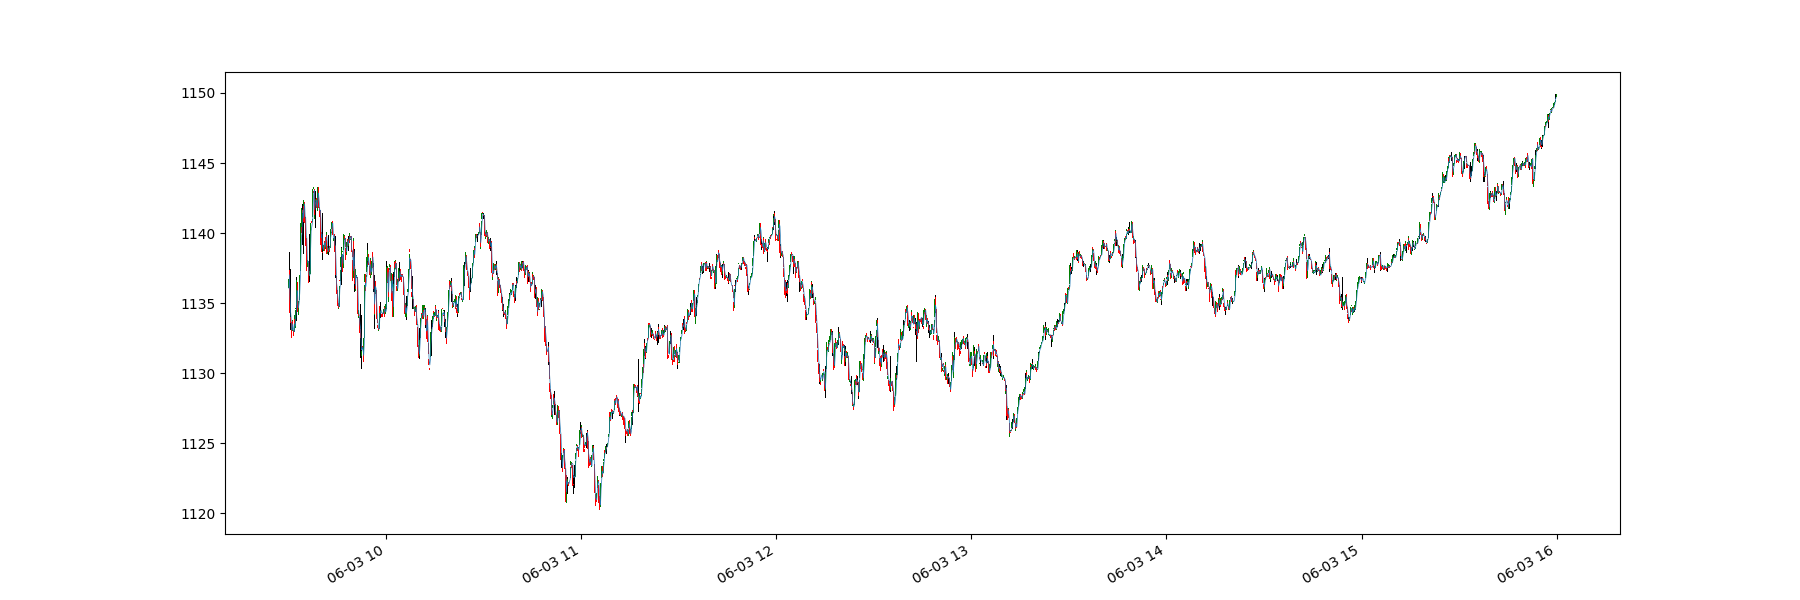

In [10]:
import pandas as pd

class ForebodingWick(Indicator):
    def __init__(self, df:pd.DataFrame):
        super().__init__(df)

    def update(self, df:pd.DataFrame):
        super().update(df)
        if not hasattr(self, 'indicator'):
            self.indicator = self.find_foreboding_wicks(self.df)
        elif self.indicator.index[-1] < self.df.index[-1]:
            self.indicator = sc.easy_concat(self.indicator, self.find_foreboding_wicks(self.df[self.indicator.index[-1]-pd.DateOffset(seconds=gb.PIP_DURATION*2):]))
    
    def get_signal(self, index:pd.Timestamp = None):
        index = super().get_signal(index)
        #span = self.indicator.loc[index-pd.DateOffset(seconds=gb.PIP_DURATION*5):index]
        #weighed_portends = span.portends_good.iloc[-5:].sum() - span.portends_ill.iloc[-5:].sum()
        
        if self.indicator.portends_good.loc[index]: return 1
        elif self.indicator.portends_ill.loc[index]: return -1
        else: return 0

    def find_foreboding_wicks(self, df:pd.DataFrame):
        '''Finds wicks which may present a foreboding sign'''
        wick = []
        for index in df.index:
            entry = df.loc[index]
            if (entry.close > entry.open): top_wick, bottom_wick = entry.high - entry.close, entry.open - entry.low
            else: top_wick, bottom_wick = entry.high - entry.open, entry.close - entry.low
            portends_good, portends_ill = bottom_wick > (top_wick * 2), top_wick > (bottom_wick * 2)
            wick.append({'index':index, 'portends_good':portends_good, 'portends_ill': portends_ill})
        return pd.DataFrame(wick).set_index('index')

        
f = ForebodingWick(data)
tb.candle_plot(data, show=True)
for index in data.index[40:]:
    signal = f.get_signal(index)
    if signal == 1: plt.axvline(index, color='green', lw=1.5, alpha=.5)
    if signal == -1: plt.axvline(index, color='red', lw=1.5, alpha=.5)

In [4]:
data = sc.get_processed_archive('NVDA', tk.d(6,3))
# df = data[tk.d(6,3,10,30): tk.d(6,3,10,31)]
# tb.candle_plot(df, 1000, 1000)

# Structural Trend Indicator
My clear next steps are as follows:
1. Figure out structural trend indicator once and for all.
2. Figure out market volatility indicator once and for all.

Once we have those two done, (and I think they'll probably be related), we can simply say "if it switches from up trend to down trend, exit the market, and also, if it's volatility is low, don't enter the market. There we go. Let's get right on that... tomorrow.

In [ ]:

class ForebodingWick(Indicator):
    def __init__(self, df:pd.DataFrame):
        super().__init__(df)

    def update(self, df:pd.DataFrame):
        super().update(df)
        if not hasattr(self, 'indicator'):
            self.indicator = self.find_foreboding_wicks(self.df)
        elif self.indicator.index[-1] < self.df.index[-1]:
            self.indicator = sc.easy_concat(self.indicator, self.find_foreboding_wicks(self.df[self.indicator.index[-1]-pd.DateOffset(seconds=gb.PIP_DURATION*2):]))
    
    def get_signal(self, index:pd.Timestamp = None):
        index = super().get_signal(index)
        #span = self.indicator.loc[index-pd.DateOffset(seconds=gb.PIP_DURATION*5):index]
        #weighed_portends = span.portends_good.iloc[-5:].sum() - span.portends_ill.iloc[-5:].sum()
        
        if self.indicator.portends_good.loc[index]: return 1
        elif self.indicator.portends_ill.loc[index]: return -1
        else: return 0

    def find_foreboding_wicks(self, df:pd.DataFrame):
        '''Finds wicks which may present a foreboding sign'''
        wick = []
        for index in df.index:
            entry = df.loc[index]
            if (entry.close > entry.open): top_wick, bottom_wick = entry.high - entry.close, entry.open - entry.low
            else: top_wick, bottom_wick = entry.high - entry.open, entry.close - entry.low
            portends_good, portends_ill = bottom_wick > (top_wick * 2), top_wick > (bottom_wick * 2)
            wick.append({'index':index, 'portends_good':portends_good, 'portends_ill': portends_ill})
        return pd.DataFrame(wick).set_index('index')


# Trend Extrapolation Via Structural Analysis

In [13]:
data = sc.get_processed_archive('NVDA', tk.d(6,3))

# Helper Function
def plot_minima_and_maxima(series:pd.Series, ma:pd.Series, mi:pd.Series):
    plt.close()
    plt.figure(figsize=(18, 6), dpi=100)
    plt.plot(series.index, series, color='green', lw=.5)

    # Plot results
    plt.scatter(mi.index, mi.values, c='blue')
    plt.scatter(ma.index, ma.values, c='orange')
    #plt.plot(series.index, series)
    plt.show()

### First Intent
Ensure that get_local_maxima_and_minima is consistent wholesale or piecemeal.

In [68]:
from scipy.signal import argrelextrema    
import pandas as pd
import numpy as np

n = 3

def get_local_maxima_and_minima(series:pd.Series, index:pd.DatetimeIndex):
    '''Returns two lists of the local maxima and minima'''
    maxima = series.iloc[argrelextrema(series[:index].values, np.greater_equal, order=n)[0]].iloc[1:-1]
    minima = series.iloc[argrelextrema(series[:index].values, np.less_equal, order=n)[0]].iloc[1:-1]
    return maxima, minima

whole_maxima, whole_minima = get_local_maxima_and_minima(data.close, data.index[-1])
# plot_minima_and_maxima(data.close, whole_maxima, whole_minima)

In [45]:
piecemeal_maxima, piecemeal_minima = None, None
for index in data.index[1:]:
    maxima, minima = get_local_maxima_and_minima(data.close, index)
    if not isinstance(piecemeal_maxima, pd.Series): piecemeal_maxima = maxima
    if not isinstance(piecemeal_minima, pd.Series): piecemeal_minima = minima
    piecemeal_maxima = sc.easy_concat(piecemeal_maxima, maxima)
    piecemeal_minima = sc.easy_concat(piecemeal_minima, minima)
# plot_minima_and_maxima(data.close, piecemeal_maxima, piecemeal_minima)

# Verify Sameness

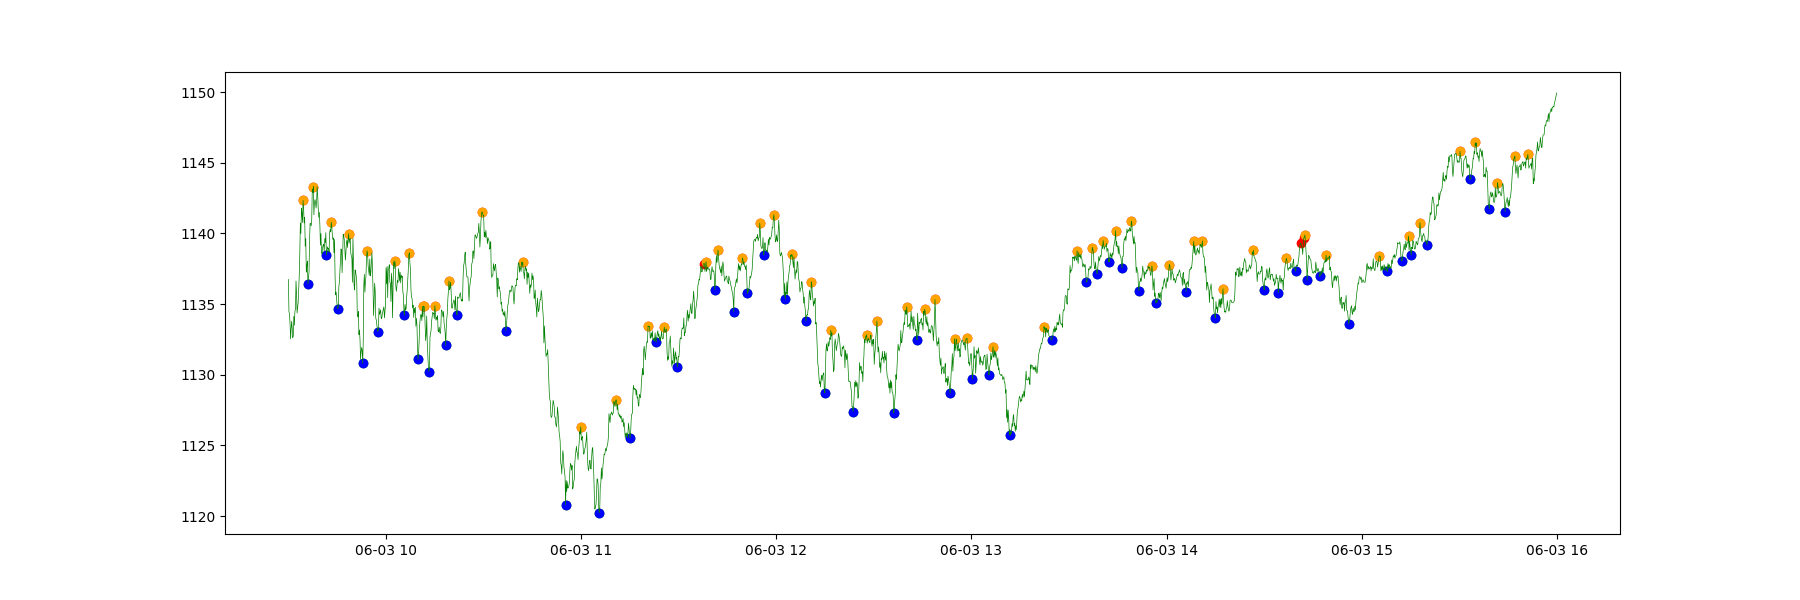

In [46]:
plt.close()
plt.figure(figsize=(18, 6), dpi=100)
plt.plot(data.close.index, data.close, color='green', lw=.5)

# Plot results
plt.scatter(piecemeal_minima.index, piecemeal_minima.values, c='green')
plt.scatter(piecemeal_maxima.index, piecemeal_maxima.values, c='red')
plt.scatter(whole_minima.index, whole_minima.values, c='blue')
plt.scatter(whole_maxima.index, whole_maxima.values, c='orange')
#plt.plot(series.index, series)
plt.show()

In [47]:
print(piecemeal_maxima.equals(whole_maxima))
print(piecemeal_minima.equals(whole_minima))
print(len(piecemeal_maxima), len(whole_maxima))

False
True
59 56


# Acceptable Comparison
Next step is creating a series of rules which can identify our trend and select "correct" min and max threshold

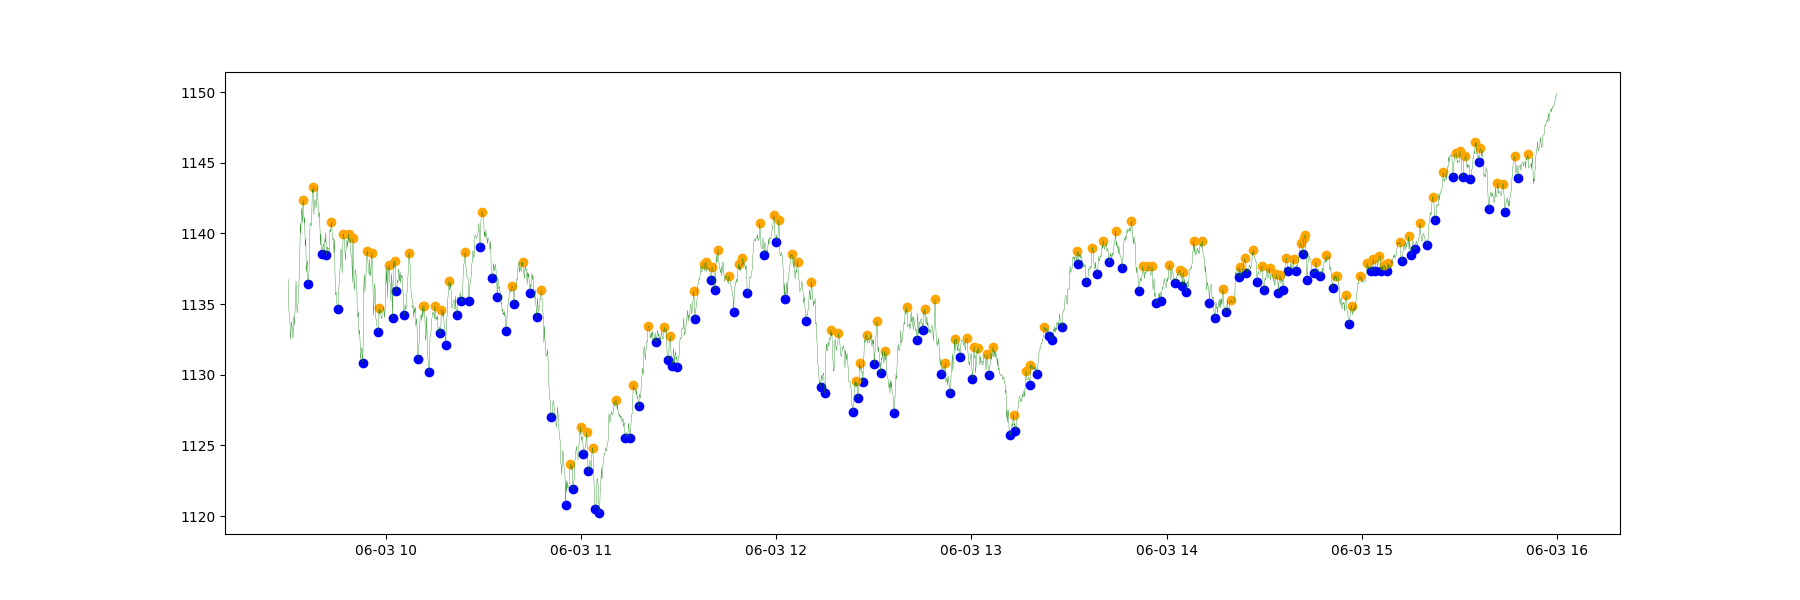

2024-06-03 09:30:20-04:00 0
2024-06-03 09:30:30-04:00 0
2024-06-03 09:30:40-04:00 0
2024-06-03 09:30:50-04:00 0
2024-06-03 09:31:00-04:00 0
2024-06-03 09:31:10-04:00 0
2024-06-03 09:31:20-04:00 0
2024-06-03 09:31:30-04:00 0
2024-06-03 09:31:40-04:00 0
2024-06-03 09:31:50-04:00 0
2024-06-03 09:32:00-04:00 0
2024-06-03 09:32:10-04:00 0
2024-06-03 09:32:20-04:00 0
2024-06-03 09:32:30-04:00 0
2024-06-03 09:32:40-04:00 0
2024-06-03 09:32:50-04:00 0
2024-06-03 09:33:00-04:00 0
2024-06-03 09:33:10-04:00 0
2024-06-03 09:33:20-04:00 0
2024-06-03 09:33:30-04:00 0
2024-06-03 09:33:40-04:00 0
2024-06-03 09:33:50-04:00 0
2024-06-03 09:34:00-04:00 0
2024-06-03 09:34:10-04:00 0
2024-06-03 09:34:20-04:00 0
2024-06-03 09:34:30-04:00 0
2024-06-03 09:34:40-04:00 0
2024-06-03 09:34:50-04:00 0
2024-06-03 09:35:00-04:00 0
2024-06-03 09:35:10-04:00 0
2024-06-03 09:35:20-04:00 0
2024-06-03 09:35:30-04:00 0
2024-06-03 09:35:40-04:00 0
2024-06-03 09:35:50-04:00 0
2024-06-03 09:36:00-04:00 0
2024-06-03 09:36:10-

In [73]:
n = 6

piecemeal_maxima, piecemeal_minima = None, None
confirmed_maxes, confirmed_mins = [], []
trend_history = []
maxima_size, minima_size = 0, 0
trend_bias = 0
for index in data.index[1:]:
    maxima, minima = get_local_maxima_and_minima(data.close, index)
    if not isinstance(piecemeal_maxima, pd.Series): piecemeal_maxima = maxima
    if not isinstance(piecemeal_minima, pd.Series): piecemeal_minima = minima
    piecemeal_maxima = sc.easy_concat(piecemeal_maxima, maxima)
    piecemeal_minima = sc.easy_concat(piecemeal_minima, minima)
    if confirmed_maxes and trend_bias == -1 and data.close.loc[index] > data.close.loc[confirmed_maxes[-1]]: trend_bias = 1
    if confirmed_mins and trend_bias == 1 and data.close.loc[index] < data.close.loc[confirmed_mins[-1]]: trend_bias = -1
    if len(piecemeal_maxima) > maxima_size:
        maxima_size, new_index = maxima_size + 1, piecemeal_maxima.index[-1]
        if not confirmed_maxes: confirmed_maxes.append(new_index); continue
    
        max_threshold, new_max = data.close.loc[confirmed_maxes[-1]], data.close.loc[new_index] 

        # Add New Max
        if new_max > max_threshold:
            confirmed_maxes.append(new_index)
            trend_bias = 1

        # Adding new lows
        if trend_bias == -1:
            confirmed_maxes.append(new_index)

    if len(piecemeal_minima) > minima_size:
        minima_size, new_index = minima_size + 1, piecemeal_minima.index[-1]
        if not confirmed_mins: confirmed_mins.append(new_index); continue
    
        min_threshold, new_min = data.close.loc[confirmed_mins[-1]], data.close.loc[new_index] 
        if new_min < min_threshold:
            confirmed_mins.append(new_index)
            trend_bias = -1

        # Adding new lows
        if trend_bias == 1:
            confirmed_mins.append(new_index)
    
    trend_history.append({'index':index, 'trend_bias':trend_bias})

    #print(confirmed_maxes)
t1, t2 = pd.DataFrame({'date':k, 'price':data.close.loc[k]} for k in confirmed_maxes).set_index('date'), pd.DataFrame({'date':k, 'price':data.close.loc[k]} for k in confirmed_mins).set_index('date')
plot_minima_and_maxima(data.close, t1, t2)
trend_df = pd.DataFrame(trend_history).set_index('index')
for index in trend_df.index:
    if trend_df.loc[index].trend_bias == 1: plt.axvline(index, color='green',lw=.5, alpha=.5)
    elif trend_df.loc[index].trend_bias == -1: plt.axvline(index, color='red',lw=.5, alpha=.5)

# Once Again Trying to Ditch the Local Maxima and Minima

In [ ]:
n = 6

piecemeal_maxima, piecemeal_minima = None, None
confirmed_maxes, confirmed_mins = [], []
trend_history = []
maxima_size, minima_size = 0, 0
trend_bias = 0
for index in data.index[1:]:
    maxima, minima = get_local_maxima_and_minima(data.close, index)
    if not isinstance(piecemeal_maxima, pd.Series): piecemeal_maxima = maxima
    if not isinstance(piecemeal_minima, pd.Series): piecemeal_minima = minima
    piecemeal_maxima = sc.easy_concat(piecemeal_maxima, maxima)
    piecemeal_minima = sc.easy_concat(piecemeal_minima, minima)
    if confirmed_maxes and trend_bias == -1 and data.close.loc[index] > data.close.loc[confirmed_maxes[-1]]: trend_bias = 1
    if confirmed_mins and trend_bias == 1 and data.close.loc[index] < data.close.loc[confirmed_mins[-1]]: trend_bias = -1
    if len(piecemeal_maxima) > maxima_size:
        maxima_size, new_index = maxima_size + 1, piecemeal_maxima.index[-1]
        if not confirmed_maxes: confirmed_maxes.append(new_index); continue
    
        max_threshold, new_max = data.close.loc[confirmed_maxes[-1]], data.close.loc[new_index] 

        # Add New Max
        if new_max > max_threshold:
            confirmed_maxes.append(new_index)
            trend_bias = 1

        # Adding new lows
        if trend_bias == -1:
            confirmed_maxes.append(new_index)

    if len(piecemeal_minima) > minima_size:
        minima_size, new_index = minima_size + 1, piecemeal_minima.index[-1]
        if not confirmed_mins: confirmed_mins.append(new_index); continue
    
        min_threshold, new_min = data.close.loc[confirmed_mins[-1]], data.close.loc[new_index] 
        if new_min < min_threshold:
            confirmed_mins.append(new_index)
            trend_bias = -1

        # Adding new lows
        if trend_bias == 1:
            confirmed_mins.append(new_index)
    
    trend_history.append({'index':index, 'trend_bias':trend_bias})

    #print(confirmed_maxes)
t1, t2 = pd.DataFrame({'date':k, 'price':data.close.loc[k]} for k in confirmed_maxes).set_index('date'), pd.DataFrame({'date':k, 'price':data.close.loc[k]} for k in confirmed_mins).set_index('date')
plot_minima_and_maxima(data.close, t1, t2)
trend_df = pd.DataFrame(trend_history).set_index('index')
for index in trend_df.index:
    if trend_df.loc[index].trend_bias == 1: plt.axvline(index, color='green',lw=.5, alpha=.5)
    elif trend_df.loc[index].trend_bias == -1: plt.axvline(index, color='red',lw=.5, alpha=.5)

In [ ]:
from enum import Enum

'''
At each step we run a function called "update"
    That function looks at the current value and compares it to the last confirmed min or max. If it is beyond the last confirmed min or max the current aspiring min or max is added to the list
    
    Ok ok, so update notices that we are sitting on a maxima:
        if it is above the last maxima then we add it to confirmed_maxima
        otherwise we set it as the aspirant
        The aspirant is only confirmed if the low goes below the last confirmed minima
'''

class TrendWatcher:
    def __init__(self, series:pd.Series, index:pd.DatetimeIndex):
        self.series, self.n = series, 5
        self.aspirant_max, self.aspirant_min = None, None
        self.reigning_max, self.reigning_min = series.index[0], series.index[0]
        self.confirmed_maxima, self.confirmed_minima = pd.Series([]), pd.Series([])
        self.backfill(index)
        #self.check_trend()

    def backfill(self, index:pd.DatetimeIndex):
        '''Backfills the trend data up to the given index (so as to bring the trend up to current)'''
        for index in self.series[:index].index: self.update(index)
        self.plot(index)
        print(self.aspirant_min)

    def update(self, index:pd.DatetimeIndex):
        '''Updates the trend for the current index'''
        value = self.series.loc[index]

        # The aspirants may ascend
        if self.aspirant_min and value > self.series.loc[self.reigning_max]:
            self.confirmed_minima.loc[self.reigning_min] = self.series.loc[self.reigning_min]
            self.reigning_min, self.aspirant_min = self.aspirant_min, None
        if self.aspirant_max and value < self.series.loc[self.reigning_min]:
            self.confirmed_maxima.loc[self.reigning_max] = self.series.loc[self.reigning_max]
            self.reigning_max, self.aspirant_max = self.aspirant_max, None

        if value > self.series.loc[self.reigning_max]: self.aspirant_max = index
        elif value < self.series.loc[self.reigning_min]: self.aspirant_min = index

        # if len(self.true_max) <= 2 and len(self.true_min) <= 2: return 0
        # if self.true_max.iloc[-2] < self.true_max.iloc[-1] and self.true_min.iloc[-2] < self.true_min[-1]: return 1
        # elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
        # else: return 0
    
    def plot(self, index:pd.DatetimeIndex = None):
        if not index: index = self.series.index[-1]
        series = self.series[:index]

        plt.figure(figsize=(18, 6), dpi=100)
        plt.plot(series.index, series)

        # Plot results
        plt.scatter(self.confirmed_maxima.index, self.confirmed_maxima.values, c='orange')
        plt.scatter(self.confirmed_minima.index, self.confirmed_minima.values, c='blue')

        # valleys, peaks = self.get_local_maxima_and_minima(index)
        # plt.scatter(valleys.index, valleys.values, c='blue')
        # plt.scatter(peaks.index, peaks.values, c='orange')
        plt.plot(series.index, series)
        #plt.show()

t = TrendWatcher(df.close, tk.d(4,30,10,10))
t_lines = []
for index in df[tk.d(4,30,10,10):].index:
    t_lines.append([index, t.update(index)])
t.plot()
for t_line in t_lines:
    if t_line[1] == 1: plt.axvline(t_line[0], color='green', alpha=.25)
    elif t_line[1] == -1: plt.axvline(t_line[0], color='red', alpha=.25)
    elif t_line[1] == 0: plt.axvline(t_line[0], color='yellow', alpha=.25)
# print(t.up_trend)

# PSAR TEST

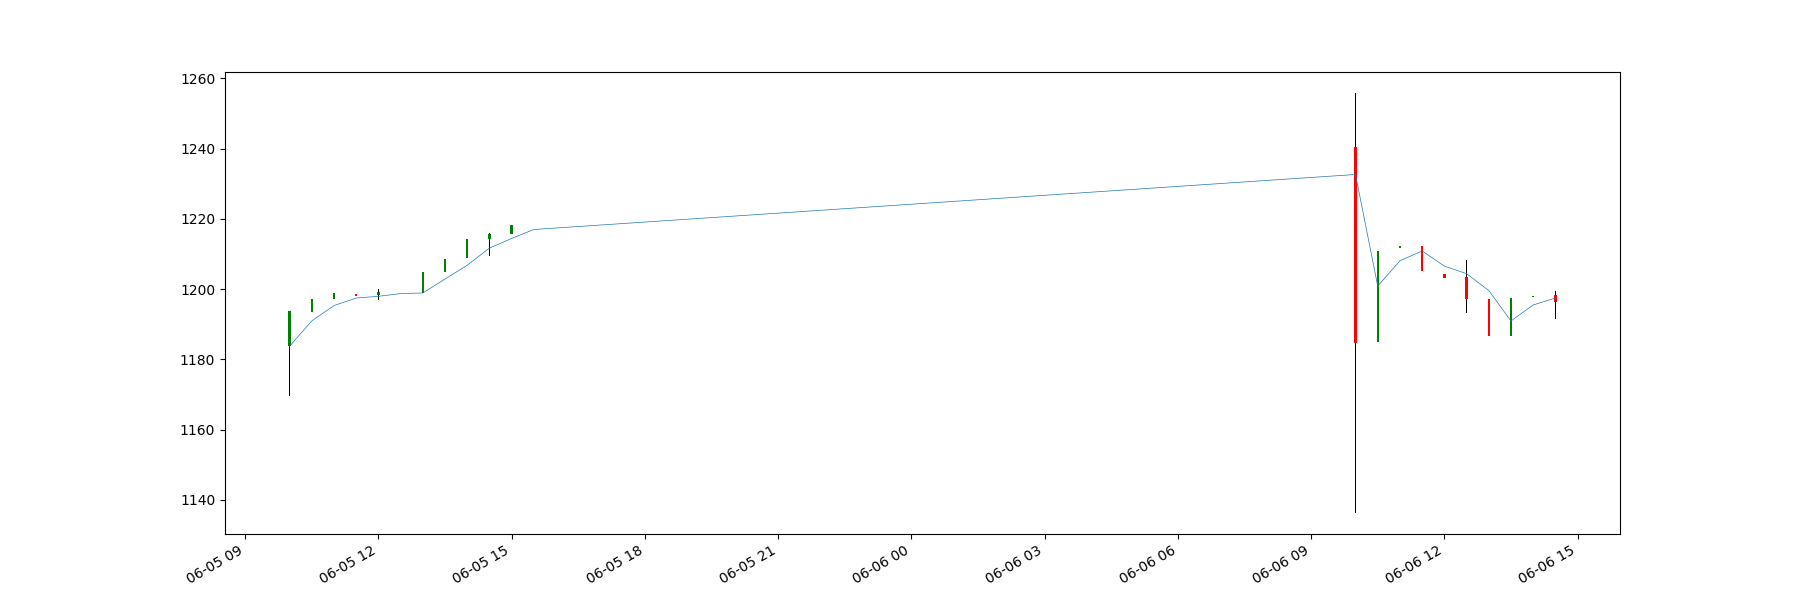

In [12]:
from lib.indicators.PSAR import PSAR
df = sc.get_processed_archive('NVDA', [tk.d(6,5), tk.d(6,6)])
p = PSAR(df)
p.indicator

# tb.candle_plot(self.ha[self.date:])
#tb.candle_plot(self.data[self.date:], 10 ,10)
tb.candle_plot(df, 10 ,10, show=True)
plt.scatter(df.index, p.indicator, s=.5)

In [12]:
%load_ext autoreload
%autoreload 2

import lib.tools.Scrivener as sc
import lib.tools.TimeKeeper as tk
import lib.tools.Toolbox as tb
import metadata.trade_configs.Globals as gb
import matplotlib.pyplot as plt
import pandas as pd
from lib.indicators.SupportResistance import SupportResistance
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = sc.get_archive('nvda', tk.d(6,7))
span = df[:tk.d(6,7,10)]

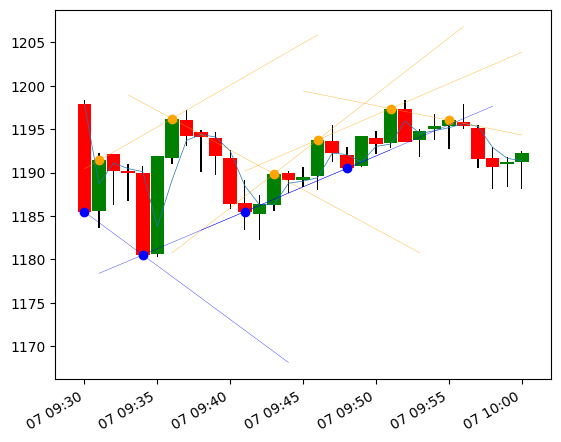

In [24]:
supres = SupportResistance(span, n=2)
tb.candle_plot(span, 25, 25)
supres.plot()

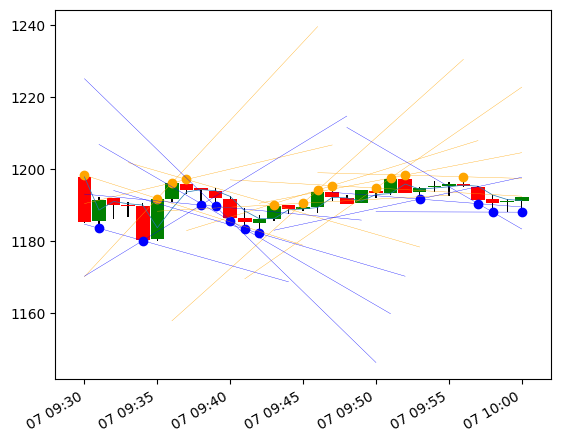

In [30]:
supres = SupportResistance(span, n=2)
tb.candle_plot(span, 25, 25)
supres.plot()